## Лабораторная работа 1. Введение в ML

В этой лабораторной вы:

- познакомитесь с базовыми библиотеками для работы с табличными данными — `numpy` и `pandas`
- поближе посмотрите на простейшие задачи машинного обучения: классификацию и регрессию
- попробуете несколько метрик и поймёте, почему выбор метрики это важно
- обучите несколько простых моделей
- увидите связь между сложностью модели и переобучением
- убедитесь, что без данных всё тлен

Загрузка самых базовых библиотек:

In [1]:
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

### [NumPy](https://numpy.org/doc/stable/user/index.html)

С 1995 numeric, с 2006 NumPy — «Numerical Python extensions» или просто «NumPy»

Возможности библиотеки NumPy:
* работать с многомерными массивами (таблицами)
* быстро вычислять математические функций на многомерных массивах

Ядро пакета NumPy — объект [ndarray](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.html)

**Важные отличия** между NumPy arrays и Python sequences: 
* NumPy array имеет фиксированную длину, которая определяется в момент его создания (в отличие от Python lists, которые могут расти динамически)
* Элементы в NumPy array должны быть одного типа
* Можно выполнять операции непосредственно над NumPy arrays

**Скорость** NumPy достигается с помощью:
* реализации на C
* векторизации и броадкастинга (broadcasting). Например, произведение массивов совместимых форм.

Теперь давайте разберёмся подробнее и сделаем что-нибудь приятное и полезное в `numpy`!

### Индексация

В NumPy работает привычная индексация Python, ура! Включая использование отрицательных индексов и срезов (slices)

<div class="alert alert-info">
<b>Замечание 1:</b> Индексы и срезы в многомерных массивах не нужно разделять квадратными скобками, 
т.е. вместо <b>matrix[i][j]</b> нужно использовать <b>matrix[i, j]</b>. Первое тоже работает, но сначала выдаёт строку i, потом элемент j в ней. 
</div>

<div class="alert alert-danger">
<b>Замечание 2:</b> Срезы в NumPy создают view, а не копии, как в случае срезов встроенных последовательностей Python (string, tuple and list).
</div>

In [2]:
ones_matrix = np.ones((5, 5))
ones_submatrix_view = ones_matrix[::2,::2] # creates a view, not copy
ones_matrix[::2,::2] = np.zeros((3, 3))
ones_submatrix_view

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

### Ссылка на Яндекс.Контест

Решения и ответы в задачах, расположенных ниже, загружайте в контест на автоматическую проверку:
https://contest.yandex.ru/contest/39295/enter

**1. (1 балл)** Реализуйте функцию, принимающую на вход два одномерных массива `first_array` и `second_array` и возвращающую матрицу, в которой первый массив соответствует первому столбцу матрицы, второй — второму.

Вероятно первое, что приходит вам на ум, это конкатенация и транспонирование:

In [3]:
def construct_matrix(first_array, second_array):
    """
    Construct matrix from pair of arrays
    :param first_array: first array
    :param second_array: second array
    :return: constructed matrix
    """
    return np.dstack([first_array.reshape(1, -1), second_array.reshape(1, -1)])[0] # <- your first right code here

In [4]:
construct_matrix(np.array([1,2,3,4]),np.array([5,6,7,8]))

array([[1, 5],
       [2, 6],
       [3, 7],
       [4, 8]])

(в скобках заметим, что конкатенировать можно vertically, horizontally, depth wise методами vstack, hstack, dstack по трём осям (0, 1 и 2, соотвественно), либо в общем случае `np.concatenate` — поиграйтесь ниже с прекрасным примером четырёхмерной точки, чтобы точно всё для себя понять)

In [5]:
p = np.arange(1).reshape([1, 1, 1, 1])
p

array([[[[0]]]])

In [6]:
print("vstack: ", np.vstack((p, p)).shape)
print("hstack: ", np.hstack((p, p)).shape)
print("dstack: ", np.dstack((p, p)).shape)

vstack:  (2, 1, 1, 1)
hstack:  (1, 2, 1, 1)
dstack:  (1, 1, 2, 1)


In [7]:
np.concatenate((p, p), axis=3).shape

(1, 1, 1, 2)

Но, поскольку операция транспонирования [делает массив non-contiguous](https://numpy.org/doc/stable/user/basics.copies.html#other-operations), мы в этой задаче **запретим** ей пользоваться и порекомедуем воспользоваться, например, методом [reshape](https://numpy.org/doc/stable/reference/generated/numpy.reshape.html).

**2. (1 балл)** Реализуйте функцию, принимающую на вход массив целых неотрицательных чисел `nums` и возвращающую самый частый элемент массива.

In [8]:
def most_frequent(nums):
    """
    Find the most frequent value in an array
    :param nums: array of ints
    :return: the most frequent value
    """
    return np.bincount(nums).argmax()

In [9]:
most_frequent(np.array([1, 2, 2, 3,3 ,3 , 4, 6, 7, 99, 99, 99, 99, 99, 99, 99]))

99

### Переходим к работе с данными

Прежде всего, загрузим данные и сделаем из них красивые pandas-таблички. Они взяты из параллели RecSys соревнования https://yandex.ru/cup/ml/. Но мы будем иметь дело не со всеми данными, а только с их частью. Данные у нас будут про заведения общественного питания (больше бюрократический терминологии!)

Задачей будет **предсказание среднего чека** (average_bill) по некоторым другим свойствам заведения.

In [10]:
base = 'data/'

In [11]:
data = pd.read_csv(base + 'organisations.csv')
features = pd.read_csv(base + 'features.csv')
rubrics = pd.read_csv(base + 'rubrics.csv')

В основном мы будем работать с табличкой `data`; остальное вам может пригодиться, если вы захотите знать, какое содержание стоит за кодами признаков.

## Изучение данных

Посмотрите на данные. В этом вам поможет метод ``head`` pandas-таблички.

In [12]:
data.head(5)

,org_id,city,average_bill,rating,rubrics_id,features_id
0,15903868628669802651,msk,1500.0,4.270968,30776 30774,3501685156 3501779478 20422 3502045016 3502045...
1,16076540698036998306,msk,500.0,4.375000,30771,1509 1082283206 273469383 10462 11617 35017794...
2,8129364761615040323,msk,500.0,4.000000,31495,10462 11177 11617 11629 1416 1018 11704 11867 ...
3,15262729117594253452,msk,500.0,4.538813,30776 30770,3501618484 2020795524 11629 11617 1018 11704 2...
4,13418544315327784420,msk,500.0,4.409091,31495,11617 10462 11177 1416 11867 3501744275 20282 ...


Полезно посмотреть внимательнее на то, с какими признаками нам предстоит работать.

* **org_id** вам не понадобится;
* **city** - город, в котором находится заведение (``msk`` или ``spb``);
* **average_bill** - средний чек в заведении - он будет нашим таргетом;
* **rating** - рейтинг заведения;
* **rubrics_id** - тип заведения (или несколько типов). Соответствие кодов каким-то человекочитаемым типам живёт в табличке ``rubrics``
* **features_id** - набор неких фичей заведения. Соответствие кодов каким-то человекочитаемым типам живёт в табличке ``features``

Обратите внимание, что **rubrics_id** и **features_id** - это не списки, а разделённые пробелами строки. Когда вам захочется работать с отдельными фичами из мешка фичей для данного заведения, вам придётся всё-таки превратить их в списки (здесь поможет метод `split` для строк).

Чтобы быстро восстанавливать по рубрикам и фичам их нормальные названия, сделайте словари вида ``код_фичи:название_фичи``

In [13]:
rubric_dict = {index: row['rubric_name'] for index, row in rubrics.iterrows()}
feature_dict = {index: row['feature_name'] for index, row in features.iterrows()}

Посмотрим, какими бывают типы заведений:

In [14]:
rubric_dict

{0: 'Булочная, пекарня',
 1: 'Бар, паб',
 2: 'Быстрое питание',
 3: 'Кафе',
 4: 'Пиццерия',
 5: 'Ресторан',
 6: 'Столовая',
 7: 'Спортбар',
 8: 'Кондитерская',
 9: 'Суши-бар',
 10: 'Кальян-бар',
 11: 'Кофейня',
 12: 'Бар безалкогольных напитков',
 13: 'Фудкорт',
 14: 'Кофе с собой'}

Мы что-то поняли про признаки, которыми нам предстоит пользоваться. Теперь время посмотреть на таргет. Вооружившись функциями ``hist`` и ``scatter`` из библиотеки ``matplotlib``, а также методом ``isna`` для pandas-таблиц разберитесь, какие значения принимают таргеты, есть ли там там выбросы, пропуски или ещё какие-то проблемы.

&nbsp;

<details>
  <summary>Когда будете готовы, кликните сюда, чтобы посмотреть ответ</summary>
    <ol>
      <li>Среди таргетов довольно много пропусков;</li>
      <li>Все таргеты - это числа, кратные 500;</li>
      <li>Есть какие-то адские значения, превышающие 100 000 (видимо, выбросы);</li>
      <li>В целом, число ресторанов с данным средним чеком быстро падает с ростом среднего чека. Для средних чеков, больших 2500, заведений уже совсем мало. Примерно у 2/3 заведений средний чек 500.</li>
    </ol> 
</details>

In [15]:
data[data['average_bill'].isna()].shape[0] / data.shape[0], '%'

(0.5203617261007624, '%')

In [16]:
data['city'].unique()

array(['msk', 'spb'], dtype=object)

<AxesSubplot:>

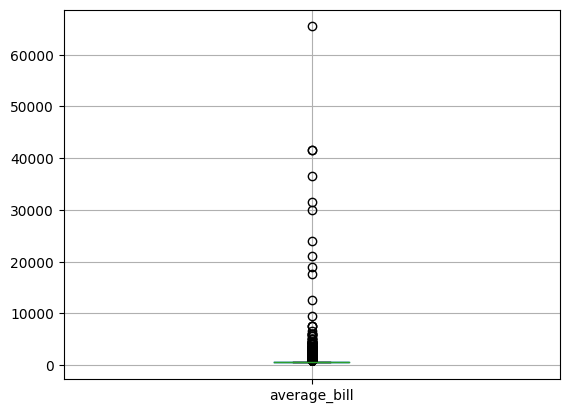

In [17]:
data[data['city'] == 'spb'].boxplot(column=['average_bill'])

<AxesSubplot:>

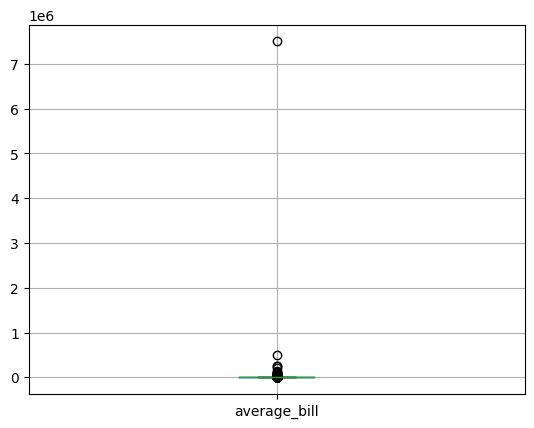

In [18]:
data[data['city'] == 'msk'].boxplot(column=['average_bill'])

(array([1.7477e+04, 3.0500e+03, 5.5600e+02, 1.1100e+02, 8.9000e+01,
        3.4000e+01, 1.2000e+01, 1.0000e+01, 1.1000e+01, 8.0000e+00]),
 array([ 500., 1350., 2200., 3050., 3900., 4750., 5600., 6450., 7300.,
        8150., 9000.]),
 <BarContainer object of 10 artists>)

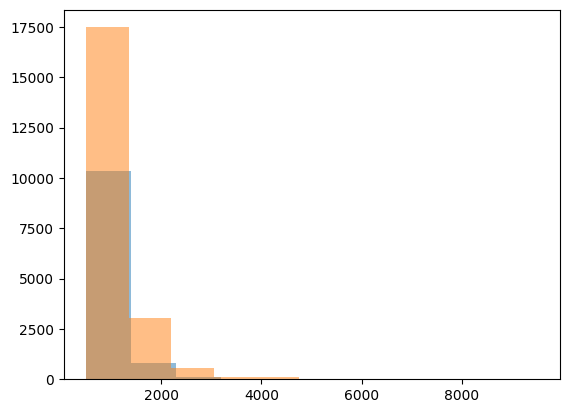

In [19]:
plt.hist(data[(data['city'] == 'spb') & (data['average_bill'] < 10000)]['average_bill'], alpha=0.5)
plt.hist(data[(data['city'] == 'msk') & (data['average_bill'] < 10000)]['average_bill'], alpha=0.5)

**Базовая очистка данных**

Раз есть треш, давайте чистить данные.

С пропусками можно бороться по-разному (даже и с пропусками в таргете), но пока мы сделаем самую простую вещь: дропнем все заведения, для которых мы не знаем средний чек. 

Уберите из них все заведения, у которых средний чек неизвестен или превышает 2500. Пока есть опасение, что их слишком мало, чтобы мы смогли обучить на них что-нибудь.

**3. (1 балл) Введите в Контест количество заведений, которое у вас получилось после очистки**.

Дальше мы будем работать с очищенными данными.

In [20]:
data = data[(~data['average_bill'].isna()) & (data['average_bill'] <= 2500)]

In [21]:
data[data['average_bill'].isna()].shape[0], data[data['average_bill'] > 2500].shape[0]

(0, 0)

In [22]:
data.shape[0]

32136

**4. (1 балл) Посчитайте и введите в Контест разность между средними арифметическими average_bill в кафе Москвы и Санкт-Петербурга. Округлите ответ до целого.**

&nbsp;

<details>
  <summary>Небольшая подсказка</summary>
  Примените часто используемый метод groupby.
</details>

In [23]:
import math

data_msk = data[data['city'] == 'msk']
data_spb = data[data['city'] == 'spb']

msk_target_avg = data_msk[data_msk.apply(lambda row: '30774' in row['rubrics_id'], axis=1)]['average_bill'].mean()
spb_target_avg = data_spb[data_spb.apply(lambda row: '30774' in row['rubrics_id'], axis=1)]['average_bill'].mean()

msk_target_avg, spb_target_avg, math.floor(msk_target_avg - spb_target_avg)

(781.0807941395052, 638.6771069441583, 142)

.Давайте ещё немного поизучаем данные. Ответьте на вопросы:

1. Есть ли разница между средними чеками в Москве и Санкт-Петербурге?
2. Коррелирует ли средний чек с рейтингом?
3. Есть ли разница в среднем чеке между ресторанами и пабами (см. соответствующие типы из ``rubrics``)?

&nbsp;

<details>
  <summary>Когда будете готовы, кликните сюда, чтобы посмотреть ответ</summary>
    <ol>
      <li>В целом, да. Вы могли бы сравнить средние (в Москве больше) или медианы (они равны, потому что уж больно много где средний чек 500). Этого, конечно, мало для того, чтобы сделать вывод. Нужно проверять какие-то статические критерии, которые изучаются в курсе по статистике. Не будем останавливаться на этом подробно. Поскольку данные совсем не нормальные, никакой t-тест не сработает; мы бы предложили использовать критерий Манна-Уитни (см. википедию и функцию mannwhitneyu из библиотеки scipy.stats).</li>
      <li>Какая-то корреляция между ними есть но уж больно неубедительная (рекомендуем построим на одном графике boxplot рейтинга по каждому значению среднего чека для визуализации). Конечно, дна становится меньше с ростом среднего чека, но, видимо, в предсказании это особо не используешь;</li>
      <li>Несомненно, в ресторанах средний чек выше. Это и невооружённым глазом видно, и с помощью критерия Манна-Уитни можно проверить.</li>
    </ol> 
</details>

## Формулируем задачу

Прежде, чем решать задачу, её надо сформулировать.

**Вопрос первый**: это классификация или регрессия? Подумайте над этим.

&nbsp;

<details>
  <summary>Когда будете готовы, кликните сюда, чтобы посмотреть ответ</summary>
    Ответ не столь однозначен, как хотелось бы. С одной стороны, таргет принимает всего четыре значения, и потому это может быть классификацией с 4 классами. С другой стороны, таргеты - это не абстрактные "треугольник", "круг", "квадрат", а вещественные числа, и когда мы вместо 500 предсказываем 2500, это явно хуже, чем вместо 1500 предсказать 2000. В целом, задачу можно решать и так, и так; мы будем смотреть на метрики обеих задач.
</details>

**Вопрос второй**: какие метрики мы будем использовать для оценки качества решения? Какие метрики вы предложили бы для этой задачи как для задачи классификации? А для этой задачи, как для задачи регрессии?

&nbsp;

<details>
  <summary>Когда будете готовы, кликните сюда, чтобы посмотреть ответ</summary>
    
    Начнём с классификации. Метрика accuracy не очень хороша из-за несбалансированности классов. Действительно, классификатор, который всегда говорит 500, будет иметь accuracy примерно 0.66, хотя это никак не отражает практическую ценность модели. Как мы увидим, самая большая проблема будет заключаться в том, чтобы научиться выделять заведения с большими чеками, а их меньше всего и в accuracy они вносят самый маленький вклад. Есть разные способы с этим бороться, один -- использовать sklearn.metrics.balanced_accuracy_score. Его идея, грубо говоря, в том, чтобы по каждому классу найти, какая доля объектов этого класса правильно классифицирована, а потом эти доли усреднить. Тогда у бессмысленного классификатора, который всем ставит 500, будет скор 1/5 (ведь классов 5), а чтобы получить прежние 2/3, нужно будет научиться в каждом классе правильно ставить хотя бы 2/3 меток.    
    
    Теперь что касается регрессии. Основых метрики две - MSE и MAE. Из первой стоит извлекать корень, чтобы получать интерпретируемые человеком значения, а вторая менее агрессивна к выбросам (впрочем, выбросов тут уже нет, мы их все выкинули). Без дополнительной информации не очень понятно, какую выбирать, можно брать любую. А выбирать надо: ведь даже банальные модели "предсказывай всегда среднее" и "предсказывай всегда медиану" будут по-разному ранжироваться этими метриками.
    
</details>

**Вопрос третий**: а не взять ли нам какую-нибудь более экзотическую метрику? Например, MAPE (определение в учебнике в главе про оценку качества моделей). А как вам такое соображение: допустим, заказчик говорит, что пользователи будут расстраиваться, только если мы завысили средний чек - так давайте поправим MSE или MAE, обнуляя те слагаемые, для которых предсказанный таргет меньше истинного. Вот это хорошая метрика или нет?

&nbsp;

<details>
  <summary>Когда будете готовы, кликните сюда, чтобы посмотреть ответ</summary>
    
    Что касается MAPE, у нас нет тех проблем, с которой она борется. Вот если бы у нас были средние чеки от 500 до миллиона, мы бы столкнулись с ситуацией, что большие ошибки для больших чеков доминировали бы в сумме для MSE и MAE (500 вместо 1000 меркнет по сравнению с 500к вместо миллиона). Говоря поэтически, мы бы оптимизировали модель для миллионеров, забыв про простых трудяг. И было бы логично перейти от парадигмы "ошибаемся на 500 рублей" к парадигме "ошибаемся на 50%". Но у нас все таргеты примерно одного порядка, MAPE нам особо ни к чему.
    
    Вторая метрика коварна тем, что её можно "накрутить" безо всякой пользы для дела. А именно, модель, которая всегда предсказывает средний чек в миллион, была бы идеальна. Но все бы расстраивались и не ходили есть. Другое дело, что можно ввести разные веса для ошибок в большую и в меньшую сторону, но опять же - пока нет показаний к тому, что это нужно.
    
</details>

## Применяем ML

Теперь время разбить данные на обучающую и тестовую выборку. Делается это с помощью функции ``train_test_split`` из пакета ``sklearn``. При этом очень важно сделать две вещи:

* Зафиксировать ``random_state=42`` (да, именно этот, а то ваши модели могут не зайти в Контест), чтобы всё, что мы делаем, было воспроизводимо (иначе от перезапуска к перезапуску числа могут меняться, и мы не будем понимать, из-за чего это происходит).
* Сделать стратификацию по таргету. В противном случае у нас в трейне и тесте могут оказаться разные пропорции классов (обычно особенно страдают мало представленные классы), что неутешительно скажется на результате.

**Обратите внимание**, что если вы побьёте выборку на train и test по-другому, ваши результаты могут не зайти в контест.

In [24]:
clean_data = data

In [25]:
clean_data_train, clean_data_test = train_test_split(
    clean_data, stratify=clean_data['average_bill'], test_size=0.33, random_state=42)

Теперь нам нужен **бейзлайн** - очень простая модель, с которой мы в дальнейшем будем сравниваться.

Поскольку мы ещё не знаем никаких умных классов моделей, все модели мы будем писать руками. А именно, мы напишем две простых модели на основе ``sklearn.baseRegressorMixin`` и ``sklearn.base.ClassifierMixin`` (посмотрите примеры в документации sklearn и сделайте так же):

* Модель для задачи регрессии, которая для всех заведений предсказывает одно число — среднее значение среднего чека;
* Модель для задачи классификации, которая для всех заведений предсказывает один класс — самый частый класс (ироничным образом он в данном случае совпадает с медианой).

**Важно!** Мы будем много раз повторять вам мантру о том, что **информация из тестовой выборки не должна протекать в процесс обучения**. Так вот, и среднее, и самый частый класс вы должны считать именно на обучающей выборке!

**5 и 6. (по 1 баллу) Напишите эти две модели и сдайте в Контест**. В процессе проверки модели будут и обучаться, и предсказывать.

Заметим, что для этих моделей нам вообще не нужны какие-то "фичи"; мы работаем только с таргетом.

У каждой модели есть (как минимум) два метода: `fit` (обучает модель по фичам `X` и таргету `y`) `predict` (предсказывает по фичам `X`)

In [26]:
from scipy.stats import mode

from sklearn.base import RegressorMixin

class MeanRegressor(RegressorMixin):
    # Predicts the mean of y_train
    def fit(self, X=None, y=None):
        '''
        Parameters
        ----------
        X : array like, shape = (n_samples, n_features)
        Training data features
        y : array like, shape = (_samples,)
        Training data targets
        '''
        
        self.result = y.mean()
        
    def predict(self, X=None):
        '''
        Parameters
        ----------
        X : array like, shape = (n_samples, n_features)
        Data to predict
        '''
        return self.result
    
from sklearn.base import ClassifierMixin

class MostFrequentClassifier(ClassifierMixin):
    # Predicts the rounded (just in case) median of y_train
    def fit(self, X=None, y=None):
        '''
        Parameters
        ----------
        X : array like, shape = (n_samples, n_features)
        Training data features
        y : array like, shape = (_samples,)
        Training data targets
        '''
        self.result = np.bincount(y).argmax()
        
    def predict(self, X=None):
        '''
        Parameters
        ----------
        X : array like, shape = (n_samples, n_features)
        Data to predict
        '''
        return self.result

Обучим наши модели

In [27]:
reg = MeanRegressor()
reg.fit(y=clean_data_train['average_bill'])

clf = MostFrequentClassifier()
clf.fit(y=clean_data_train['average_bill'])

In [28]:
reg.predict([])

752.1016209186754

In [29]:
clf.predict([])

500

In [30]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import balanced_accuracy_score

mean_squared_error(
    clean_data_test['average_bill'],
    list(map(reg.predict, range(clean_data_test.shape[0])))
)

201344.60285540455

In [31]:
balanced_accuracy_score(
    list(map(int, clean_data_test['average_bill'])),
    list(map(int, map(clf.predict, range(clean_data_test.shape[0]))))
)

0.2

Обучите модели и оцените их качество на тестовой выборке. В качестве метрик возьмём RMSE (``np.sqrt`` от ``sklearn.metrics.mean_squared_error``) и ``sklearn.metrics.balanced_accuracy_score``.


Для регрессионной модели имеет смысл считать только RMSE (значения будут не кратны 500, точно мы угадывать не будем никогда), а вот для классификационной можно найти обе метрики. Сделайте это. Какая модель оказалась лучше по RMSE?

<details>
  <summary>Когда будете готовы, кликните сюда</summary>
    
  Казалось бы, регрессор никогда не угадывает, но он в каком-то смысле лучше классификатора - справедливо ли это? Возможно. Несуществующий пользователь модели вряд ли будет задавать вопросы "почему средний чек не кратен 500?" Ну, выдали около 800 - ок, понятно.
    
</details>

## Усложнение модели

Бейзлайны будут нашей отправной точкой. Строя дальнейшие модели, мы будем спрашивать себя: получилось ли лучше бейзлайна? Если нет или если не особо, то в чём смысл усложнения?

Начнём с использования фичи ``city``. Мы уже видели, что в разных городах и средние чеки разные. Легко проверить, что *медиана* средних чеков всё же одна и та же и в Москве, и в Санкт-Петербурге (ох уж этот вездесущий средний чек 500!), поэтому с классификатором мы ничего не сделаем. Но вот регрессор можно попробовать починить.

**7. (1 балл) Напишите регрессор, для каждого заведения предсказывающий среднее значение в том же городе (на обучающей выборке, конечно) и сдайте его в Контест**. Вам может помочь то, что булевы `pandas` и `numpy` столбцы можно умножать на численные — в такой ситуации False работает, как ноль, а True как единица.

In [35]:
from sklearn.base import RegressorMixin
import pandas as pd
from uuid import uuid1

class CityMeanRegressor(RegressorMixin):
    def fit(self, X: pd.DataFrame=None, y: pd.Series=None):
        self.data = X
        self.data['my_custom_target_column'] = y
        self.target = y
        
    def predict(self, X: pd.DataFrame=None):
        tmp_col = str(uuid1())
        X[tmp_col] = 0
        
        for city in X['city'].unique():
            avg_bill = self.target[self.data['city'] == city].mean()
            
            print(city, avg_bill)
            
            X.loc[(X['city'] == city), tmp_col] = avg_bill
            
        result = X[tmp_col]
        X = X.drop(columns=[tmp_col])
        self.data = self.data.drop(columns=['my_custom_target_column'])
        
        return result

In [36]:
reg_city = CityMeanRegressor()
reg_city.fit(X=clean_data_train, y=clean_data_train['average_bill'])

mean_squared_error(
    clean_data_test['average_bill'],
    reg_city.predict(clean_data_test)
)

spb 677.7104465814781
msk 792.6111908177905


198119.64335056383

Обучите регрессор и сравните его по метрике RMSE с бейзлайнами. Получилось ли улучшить метрику?

Лучше стало, но, правда, не очень сильно. В этот момент очень важно не просто радовать руководителя приростом в третьем знаке, но и думать о том, что происходит.

Средний средний чек по Москве равен 793, в Санкт-Петербурге - 676, а в целом - 752 рубля. MSE, увы, не поможет вам ответить на вопрос, стало ли лучше пользователю, если вы ему вместо 752 рублей назвали 793. Здесь вскрывается весьма существенный порок MSE в этой задаче. Дело в том, что наш изначальный таргет делит заведения на некоторые "ценовые категории", и различие в средних чеках 500 и 1000 в самом деле существенно. Наверное, мы хотели бы как раз правильно предсказывать ценовые категории. Но MSE не очень помогает нам об этом судить. Дальше мы ещё подумаем, как это исправить.

В любом случае, несмотря на улучшение метрики, мы пока не можем судить, стало ли по жизни лучше от усложнения модели.

Поручинившись немного, возьмём на вооружение другую идею. Давайте использовать типы заведений! 

Но с типами есть некоторая проблема: в столбце ``rubrics_id`` не всегда один идентификатор, часто их несколько, и всего комбинаций довольно много. Чтобы не возиться с малочисленными типами, давайте сольём их в один безликий ``other``.

Итак, добавьте в обучающие и тестовые данные столбец ``modified_rubrics``, в котором будет то же, что и в ``rubrics_id``, если соответствующая комбинация рубрик содержит хотя бы 100 заведений из обучающей (!) выборки, и строка ``other`` в противном случае.

Здесь вам поможет контейнер ``Counter`` из библиотеки ``collections``.

In [220]:
counts = clean_data_train['rubrics_id'].value_counts()

clean_data_train['modified_rubrics'] = clean_data_train['rubrics_id'].apply(
    lambda rubric_id: rubric_id if counts[rubric_id] >= 100 else 'other'
)

clean_data_test['modified_rubrics'] = clean_data_test['rubrics_id'].apply(
    lambda rubric_id: rubric_id if rubric_id in counts and counts[rubric_id] >= 100 else 'other'
)

Теперь настало время написать могучий классификатор, который по заведению предсказывает медиану средних чеков среди тех в обучающей выборке, у которых с ним одинаковые `modified_rubrics` и город (вы спросите, почему медиану, а не самый частый -- спишем это на вдохновение; самый частый тоже можно брать - но медиана работает лучше).

**8. (2 балла) Напишите классификатор и сдайте в Контест**.

In [221]:
from uuid import uuid1
import pandas as pd
from sklearn.base import ClassifierMixin

class CityRubricClassifier(ClassifierMixin):
    # Predicts the rounded (just in case) median of y_train
    def fit(self, X: pd.DataFrame=None, y: pd.Series=None):
        self.data = X.copy()
        self.target = y.copy()
        
    def predict(self, X=None):
        tmp_target_column = str(uuid1())
        self.data[tmp_target_column] = self.target
        tmp_median_df = self.data.groupby(['city', 'modified_rubrics']).agg({tmp_target_column:'median'})

        result = X.join(
            tmp_median_df,
            on=['city', 'modified_rubrics'],
            how='left'
        )[tmp_target_column]
        
        self.data.drop(columns=[tmp_target_column])
        
        return result

In [222]:
city_rub_ref = CityRubricClassifier()
city_rub_ref.fit(X=clean_data_train.drop(columns=['average_bill']), y=clean_data_train['average_bill'])

In [223]:
mean_squared_error(
    clean_data_test['average_bill'],
    city_rub_ref.predict(clean_data_test)
)

155209.80669495522

Сравните обученный классификатор по метрикам RMSE и balanced_accuracy_score с нашими бейзлайнами. Получилось ли улучшить?

Обратите внимание что рост accuracy по сравнению с бейзлайном при этом на порядок меньше:

accuracy_score

Predict most frequent:  0.6947666195190948

Predict by rubric and city:  0.7095709570957096

Для диагностики напечатайте для каждого класса тестовой выборки, сколько в нём объектов и скольким из них наш классификатор приписал правильный класс. Что вы видите?

&nbsp;

<details>
  <summary>Когда будете готовы, кликните сюда, чтобы посмотреть ответ</summary>
    
  Вы, вероятно, видите то, что мы стали однозначно лучше по сравнению с бейзлайном детектировать средний чек 1000 и 1500 (хотя всё равно не очень хорошо + ценой ухудшения качества на среднем чеке 500), а вот чеки 2000 и 2500 нам ну никак не даются.
    
</details>

**Кстати**. А вы понимаете, почему приведённый выше пайплайн классификации был не очень удачным с точки зрения архитектуры? Почему его было бы правильнее воплотить по-другому?

&nbsp;

<details>
  <summary>Когда будете готовы, кликните сюда, чтобы посмотреть ответ</summary>
Собственно говоря, и не было никакого пайплайна. К счастью, у нас была одна обучающая выборка, мы на ней посчитали список рубрик для modified_rubrics и радовались жизни. Но если бы нам надо было переобучать всё на новых данных, пришлось бы помнить, что их надо везде пересчитать (ведь у нас могли появиться новые рубрики с хотя бы 100 представителями). А уж никакую кросс-валидацию (кто знает - тот поймёт) с нашим подходом к делу и вовсе бы не получилось сделать без боли.
    
Поэтому в следующей лабораторной вы научитесь делать честные пайплайны, в которых преобразование данных, генерация фичей и обучение классификатора будут объединены в один понятный процесс, происходящий на этапе fit.
</details>

## Слишком простые и слишком сложные модели

Бейзлайны у нас слишком просты и потому не очень полезны в жизни. Но если сложность модели растёт бесконтрольно, то тоже получается плохо.

Давайте рассмотрим конкретный пример. Создадим классификатор, использующий одновременно `rubrics_id` и `features_id`. 

Сделайте следующее:

- для каждого объекта обучающей выборки сконкатенируйте строку `rubrics_id` с разделителем (например, буквой 'q') и содержимым `features_id`. Полученный столбец озаглавьте `modified_features`. Это не самый клёвый способ заиспользовать все фичи, но сейчас пока сойдёт. Причём на сей раз не будем выкидывать мало представленные значения (вся информация важна, не так ли?).
- при этом для тестовой выборке заменяйте на строку `other` все конкатенации, которые не встретились в обучающей выборке.

То есть элементы в этом столбце будут иметь вид `other` или `30776 30774 q 3502045032 11741 3502045016 1046...`.

In [224]:
clean_data_test['average_bill'].unique()

array([1000.,  500., 2000., 1500., 2500.])

In [225]:


clean_data_train['modified_features'] = clean_data_train['rubrics_id'] + ' q ' + clean_data_train['features_id']
clean_data_test['modified_features'] = clean_data_test['rubrics_id'] + ' q ' + clean_data_test['features_id']

clean_data_test.loc[
    clean_data_test['modified_features'].isin(clean_data_train['modified_features'].unique())
]['modified_features'] = 'other'



/var/folders/dz/7q462fh56rg95y4_6lnqmrvr0000gq/T/ipykernel_1894/784415994.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data_test.loc[clean_data_test['modified_features'].isin(clean_data_train['modified_features'].unique())]['modified_features'] = 'other'


In [230]:
clean_data_test['average_bill'].unique()

array([1000.,  500., 2000., 1500., 2500.])

In [266]:
from uuid import uuid1
import pandas as pd
from sklearn.base import ClassifierMixin

class RubricFeatureClassifier(ClassifierMixin):
    # Predicts the rounded (just in case) median of y_train
    def fit(self, X: pd.DataFrame=None, y: pd.Series=None):
        self.data = X.copy()
        self.target = y.copy()
        self.default_value = y.median()
        
    def predict(self, X=None):
        tmp_target_column = str(uuid1())
        self.data[tmp_target_column] = self.target
        tmp_median_df = self.data.groupby(['modified_features']).agg({tmp_target_column:'median'})

        result = X.join(
            tmp_median_df,
            on='modified_features',
            how='left'
        )
        result.loc[result[tmp_target_column].isna()] = self.default_value
        result = result[tmp_target_column]
        
        self.data.drop(columns=[tmp_target_column])
        
        return result
    
rub_feature_clf = RubricFeatureClassifier()
rub_feature_clf.fit(X=clean_data_train.drop(columns=['average_bill']), y=clean_data_train['average_bill'])

In [251]:
rub_feature_clf.predict(clean_data_test).astype(int).to_csv('data/task_9.csv', header=False)

In [273]:
print(round(mean_squared_error(
    clean_data_train['average_bill'],
    rub_feature_clf.predict(clean_data_train),
    squared=False
), 2))
print(round(balanced_accuracy_score(
    clean_data_train['average_bill'],
    rub_feature_clf.predict(clean_data_train)
), 2))
print(round(mean_squared_error(
    clean_data_test['average_bill'],
    rub_feature_clf.predict(clean_data_test),
    squared=False
), 2))
print(round(balanced_accuracy_score(
    clean_data_test['average_bill'],
    rub_feature_clf.predict(clean_data_test)
), 2))

32.42
0.99
513.99
0.2


/Users/platon.fedorov/opt/anaconda3/envs/yandex-data-analysis-school/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2006: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/Users/platon.fedorov/opt/anaconda3/envs/yandex-data-analysis-school/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2006: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Теперь обучите классификатор, который для заведения предсказывает медиану среднего чека по всем объектам тестовой выборки с таким же, как у него, значением `modified_features`, а если такого в обучающей выборке нет, то глобальную медиану среднего чека по всей обучающей выборке.

**9. (2 балла) Загрузите в Контест предсказания этого классификатора на тестовой выборке**

Мы ждём файла **.csv**, у которого в каждой строке будет только одно число - предсказание классификатора.

Возможно, вам будет полезна библиотека ``tqdm``, позволяющая отслеживать в реальном времени, сколько времени уже крутится цикл и сколько итераций ещё осталось. Впрочем, если вы всё написали нормально, то должно работать не очень долго.

Модель, очевидно, очень сложная. Число параметров (различных категорий) в ней сопоставимо с числом объектов в обучающей выборке. А получилось ли хорошо?

Давайте посчитаем RMSE и balanced_accuracy_score на обучающей и на тестовой выборках. 

**10. (1 балл) Введите их в Контест**

Налицо переобучение: на трейне метрики отличные, на тесте - вообще никакие

В общем, не гонитесь за чрезмерной сложностью модели..

## ML без данных что компутер без электричества

Возможно, вы смотрите на полученные выше результаты и думаете: вот если бы мы не какие-то убогие медианы предсказывали, а гоняли бы нейросети, то тут-то бы всё и получилось!

Но, увы, совсем даже не всегда от счастья нас отделяет выбор хорошей модели (и стратегии обучения). Если данные не очень, то даже самая крутая модель не сработает. В этой ситуации нужно либо добывать новые фичи каким-то образом, либо собирать новые данные (увеличивать датасет), либо просто бросать задачу.

Давайте посмотрим, что выжмет из наших данных одна из самых мощных моделей для табличных данных - градиентный бустинг на решающих деревьях в исполнении [CatBoost](https://catboost.ai/).

Но прежде, чем сделать fit, нам надо облагородить данные. Несмотря на то, что CatBoost отлично работает с категориальными фичами, мешок признаков из `rubrics_id` или `features_id` может ему оказаться не по зубам. Поэтому мы соберём датасет в пристойную матрицу, создав для каждого типа рубрик и фичей отдельный столбец и записав там единицы для тех объектов, у которых эта рубрика или фича имеет место.

В матрице почти все элементы будут нулями. Такие матрицы считаются **разреженными** и их можно хранить гораздо эффективней, чем просто таблицей. Этим и займёмся)

Есть несколько форматов хранения разреженных матриц (многие из них реализованы в [пакете sparse библиотеки scipy](https://docs.scipy.org/doc/scipy/reference/sparse.html)), и каждый пригоден для чего-то своего.

Создавать разреженную матрицу лучше в [формате COO](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.coo_array.html#scipy.sparse.coo_array). Он предполагает, что разреженная матрица задаётся в виде трёх списков: `row`, `col`, `data`, причём каждая тройка `(row[i], col[i], data[i])` кодирует элемент со значением `data[i]`, стоящий на позиции `(row[i], col[i])`. Считается, что на позициях `(row, col)`, которые ни разу не встретились, стоят нули.

Нетрудно видеть, что заполнять такую матрицу - одно удовольствие, и особенно этому помогает тот факт, что **пара `(row, col)` может встретиться несколько раз** (тогда в итоговой матрице на соответствующей позиции стоит сумма соответствующих `data[i]`). Но, с другой стороны, почти ничего другого с такой матрицей не сделаешь: произвольного доступа к элементам она не предоставляет, умножить её тоже особо ничего не умножишь. Поэтому для дальнейшего использования созданную таким образом матрицу преобразуют в один из более удобных форматов, например, [CSR (compressed sparse row)](https://scipy-lectures.org/advanced/scipy_sparse/csr_matrix.html). Он, к примеру, хорошо подходит для умножения на вектор (потому что матрица хранится по строкам). Не будем разбирать его подробно, но можете почитать по ссылке, если интересно.

Вам нужно будет превратить обучающие и тестовые данные в разреженные матрицы `sparse_data_train` и `sparse_data_test` соответственно, таким образом, что:

- столбец `city` превратится в столбец из единиц и нулей (например, 1 - Москва, 0 - Питер);
- столбец `rating` перекочует в разреженные матрицы без изменений;
- каждый типы рубрик и каждая фича превратятся в отдельный 0-1-принак;

В тестовой выборке будут фичи, которых в обучающей выборке не было. С ними можно по-разному работать, но давайте создадим дополнительную фантомную фичу `feature_other`, в которой будет то, сколько неизвестных по обучающей выборке фичей есть у данного объекта.

In [342]:
def encode_city(train, test):
    from sklearn.preprocessing import LabelEncoder
    
    city_encoder = preprocessing.LabelEncoder()
    city_encoder.fit(clean_data_train['city'])
    
    train['city_encoded'] = city_encoder.transform(train['city'])
    test['city_encoded'] = city_encoder.transform(test['city'])
    

def add_zero_columns(train, test, col_names):
    train = train.join(pd.DataFrame(
        {col_name: 0 for col_name in col_names},
        index=train.index
    ))
    
    test = test.join(pd.DataFrame(
        {col_name: 0 for col_name in col_names},
        index=test.index
    ))
                     
    return train, test


def drop_equal_columns_train(data):
    columns_to_remove = []
    
    for column in data.columns:
        if (data[column] == 0).all():
            columns_to_remove.append(column)

    return data.drop(columns=columns_to_remove)


def drop_equal_columns_test(train_data, test_data):
    columns_to_remove = []
    
    for column in test_data.columns:
        if (test_data[column] == 0).all() and column not in train_data.columns:
            columns_to_remove.append(column)

    return test_data.drop(columns=columns_to_remove)

In [355]:
import gc

clean_data_train, clean_data_test = train_test_split(
    clean_data, stratify=clean_data['average_bill'], test_size=0.33, random_state=42)

ctb_train = clean_data_train.copy()
ctb_test = clean_data_test.copy()
    
encode_city(ctb_train, ctb_test)

rubrics_list = list(map(str, rubrics['rubric_id'].to_list()))
features_list = list(map(str, features['feature_id'].to_list()))

ctb_train, ctb_test = add_zero_columns(ctb_train, ctb_test, rubrics_list)
ctb_train, ctb_test = add_zero_columns(ctb_train, ctb_test, features_list)

for rubric_id in rubrics_list:
    ctb_train.loc[ctb_train['rubrics_id'].str.contains(str(rubric_id)), rubric_id] = 1
    ctb_test.loc[ctb_test['rubrics_id'].str.contains(str(rubric_id)), rubric_id] = 1

for feature_id in features_list:
    ctb_train.loc[ctb_train['features_id'].str.contains(str(feature_id)), feature_id] = 1
    ctb_test.loc[ctb_test['features_id'].str.contains(str(feature_id)), feature_id] = 1

ctb_train = drop_equal_columns_train(ctb_train)
ctb_test = drop_equal_columns_test(ctb_train, ctb_test)

feautres_test_only = list(set(ctb_test.columns).difference(set(ctb_train.columns)))
ctb_train['feature_other'] = 0
ctb_test['feature_other'] = ctb_test[feautres_test_only].sum(axis=1)
ctb_test = ctb_test.drop(columns=feautres_test_only)


ctb_train = ctb_train.drop(columns=['org_id', 'city', 'rubrics_id', 'features_id'])
ctb_test = ctb_test.drop(columns=['org_id', 'city', 'rubrics_id', 'features_id'])

x_train, y_train = ctb_train.drop(columns=['average_bill']), ctb_train['average_bill']
x_test, y_test = ctb_test.drop(columns=['average_bill']), ctb_test['average_bill']

del ctb_train, ctb_test, feautres_test_only, rubrics_list, features_list, clean_data_test, clean_data_train

gc.collect()

70

In [359]:
import scipy

x_train_csr = scipy.sparse.csr_matrix(x_train.values)
x_test_csr = scipy.sparse.csr_matrix(x_test.values)

Данные готовы, и теперь можно запустить катбуст

In [361]:
from catboost import CatBoostClassifier

In [362]:
# <USE IT!>
clf = CatBoostClassifier()
clf.fit(x_train_csr, y_train)

Learning rate set to 0.092536
0:	learn: 1.4342904	total: 99.4ms	remaining: 1m 39s
1:	learn: 1.3172527	total: 127ms	remaining: 1m 3s
2:	learn: 1.2266285	total: 153ms	remaining: 50.8s
3:	learn: 1.1565291	total: 179ms	remaining: 44.5s
4:	learn: 1.0985861	total: 206ms	remaining: 40.9s
5:	learn: 1.0469854	total: 235ms	remaining: 38.9s
6:	learn: 1.0061031	total: 262ms	remaining: 37.2s
7:	learn: 0.9701702	total: 289ms	remaining: 35.8s
8:	learn: 0.9385453	total: 314ms	remaining: 34.6s
9:	learn: 0.9118185	total: 341ms	remaining: 33.8s
10:	learn: 0.8895246	total: 368ms	remaining: 33s
11:	learn: 0.8673816	total: 394ms	remaining: 32.5s
12:	learn: 0.8487064	total: 422ms	remaining: 32s
13:	learn: 0.8324794	total: 452ms	remaining: 31.8s
14:	learn: 0.8169144	total: 478ms	remaining: 31.4s
15:	learn: 0.8048038	total: 501ms	remaining: 30.8s
16:	learn: 0.7922686	total: 527ms	remaining: 30.5s
17:	learn: 0.7830198	total: 551ms	remaining: 30s
18:	learn: 0.7743105	total: 575ms	remaining: 29.7s
19:	learn: 0.76

160:	learn: 0.6110871	total: 4.26s	remaining: 22.2s
161:	learn: 0.6107627	total: 4.29s	remaining: 22.2s
162:	learn: 0.6104360	total: 4.32s	remaining: 22.2s
163:	learn: 0.6103905	total: 4.34s	remaining: 22.1s
164:	learn: 0.6101819	total: 4.37s	remaining: 22.1s
165:	learn: 0.6099901	total: 4.39s	remaining: 22.1s
166:	learn: 0.6099673	total: 4.42s	remaining: 22s
167:	learn: 0.6096742	total: 4.44s	remaining: 22s
168:	learn: 0.6095776	total: 4.47s	remaining: 22s
169:	learn: 0.6094347	total: 4.49s	remaining: 21.9s
170:	learn: 0.6092851	total: 4.51s	remaining: 21.9s
171:	learn: 0.6089647	total: 4.54s	remaining: 21.9s
172:	learn: 0.6087134	total: 4.56s	remaining: 21.8s
173:	learn: 0.6084437	total: 4.59s	remaining: 21.8s
174:	learn: 0.6083242	total: 4.62s	remaining: 21.8s
175:	learn: 0.6082029	total: 4.64s	remaining: 21.7s
176:	learn: 0.6078655	total: 4.67s	remaining: 21.7s
177:	learn: 0.6076382	total: 4.7s	remaining: 21.7s
178:	learn: 0.6075456	total: 4.72s	remaining: 21.7s
179:	learn: 0.60750

322:	learn: 0.5824284	total: 8.43s	remaining: 17.7s
323:	learn: 0.5821926	total: 8.46s	remaining: 17.7s
324:	learn: 0.5821384	total: 8.49s	remaining: 17.6s
325:	learn: 0.5819874	total: 8.51s	remaining: 17.6s
326:	learn: 0.5818178	total: 8.54s	remaining: 17.6s
327:	learn: 0.5817449	total: 8.56s	remaining: 17.5s
328:	learn: 0.5817328	total: 8.58s	remaining: 17.5s
329:	learn: 0.5814780	total: 8.61s	remaining: 17.5s
330:	learn: 0.5813059	total: 8.64s	remaining: 17.5s
331:	learn: 0.5812043	total: 8.66s	remaining: 17.4s
332:	learn: 0.5810903	total: 8.69s	remaining: 17.4s
333:	learn: 0.5810162	total: 8.72s	remaining: 17.4s
334:	learn: 0.5808313	total: 8.74s	remaining: 17.4s
335:	learn: 0.5807301	total: 8.77s	remaining: 17.3s
336:	learn: 0.5806951	total: 8.79s	remaining: 17.3s
337:	learn: 0.5804139	total: 8.82s	remaining: 17.3s
338:	learn: 0.5800922	total: 8.85s	remaining: 17.2s
339:	learn: 0.5800674	total: 8.87s	remaining: 17.2s
340:	learn: 0.5798228	total: 8.9s	remaining: 17.2s
341:	learn: 0

482:	learn: 0.5603508	total: 12.5s	remaining: 13.4s
483:	learn: 0.5601800	total: 12.5s	remaining: 13.4s
484:	learn: 0.5601302	total: 12.6s	remaining: 13.3s
485:	learn: 0.5601124	total: 12.6s	remaining: 13.3s
486:	learn: 0.5599546	total: 12.6s	remaining: 13.3s
487:	learn: 0.5596758	total: 12.6s	remaining: 13.3s
488:	learn: 0.5593702	total: 12.7s	remaining: 13.2s
489:	learn: 0.5592082	total: 12.7s	remaining: 13.2s
490:	learn: 0.5591355	total: 12.7s	remaining: 13.2s
491:	learn: 0.5589236	total: 12.7s	remaining: 13.2s
492:	learn: 0.5587564	total: 12.8s	remaining: 13.1s
493:	learn: 0.5585949	total: 12.8s	remaining: 13.1s
494:	learn: 0.5585849	total: 12.8s	remaining: 13.1s
495:	learn: 0.5585224	total: 12.8s	remaining: 13.1s
496:	learn: 0.5584452	total: 12.9s	remaining: 13s
497:	learn: 0.5580209	total: 12.9s	remaining: 13s
498:	learn: 0.5577184	total: 12.9s	remaining: 13s
499:	learn: 0.5574207	total: 13s	remaining: 13s
500:	learn: 0.5572982	total: 13s	remaining: 12.9s
501:	learn: 0.5572500	to

646:	learn: 0.5375915	total: 16.8s	remaining: 9.15s
647:	learn: 0.5375107	total: 16.8s	remaining: 9.13s
648:	learn: 0.5374454	total: 16.8s	remaining: 9.1s
649:	learn: 0.5372545	total: 16.9s	remaining: 9.08s
650:	learn: 0.5372042	total: 16.9s	remaining: 9.05s
651:	learn: 0.5371169	total: 16.9s	remaining: 9.03s
652:	learn: 0.5369258	total: 16.9s	remaining: 9s
653:	learn: 0.5368171	total: 17s	remaining: 8.97s
654:	learn: 0.5367169	total: 17s	remaining: 8.95s
655:	learn: 0.5366494	total: 17s	remaining: 8.92s
656:	learn: 0.5364872	total: 17s	remaining: 8.9s
657:	learn: 0.5363901	total: 17.1s	remaining: 8.87s
658:	learn: 0.5362348	total: 17.1s	remaining: 8.85s
659:	learn: 0.5361380	total: 17.1s	remaining: 8.82s
660:	learn: 0.5360632	total: 17.2s	remaining: 8.8s
661:	learn: 0.5358050	total: 17.2s	remaining: 8.77s
662:	learn: 0.5356047	total: 17.2s	remaining: 8.75s
663:	learn: 0.5355340	total: 17.2s	remaining: 8.72s
664:	learn: 0.5353159	total: 17.3s	remaining: 8.7s
665:	learn: 0.5351438	total

810:	learn: 0.5175103	total: 21s	remaining: 4.9s
811:	learn: 0.5174502	total: 21s	remaining: 4.87s
812:	learn: 0.5173736	total: 21.1s	remaining: 4.85s
813:	learn: 0.5172348	total: 21.1s	remaining: 4.82s
814:	learn: 0.5170578	total: 21.1s	remaining: 4.79s
815:	learn: 0.5170074	total: 21.1s	remaining: 4.77s
816:	learn: 0.5169894	total: 21.2s	remaining: 4.74s
817:	learn: 0.5169486	total: 21.2s	remaining: 4.72s
818:	learn: 0.5167297	total: 21.2s	remaining: 4.69s
819:	learn: 0.5166726	total: 21.2s	remaining: 4.66s
820:	learn: 0.5165474	total: 21.3s	remaining: 4.64s
821:	learn: 0.5164339	total: 21.3s	remaining: 4.61s
822:	learn: 0.5163555	total: 21.3s	remaining: 4.58s
823:	learn: 0.5162095	total: 21.3s	remaining: 4.56s
824:	learn: 0.5161804	total: 21.4s	remaining: 4.53s
825:	learn: 0.5159267	total: 21.4s	remaining: 4.51s
826:	learn: 0.5157638	total: 21.4s	remaining: 4.48s
827:	learn: 0.5155806	total: 21.4s	remaining: 4.46s
828:	learn: 0.5155297	total: 21.5s	remaining: 4.43s
829:	learn: 0.515

975:	learn: 0.4984747	total: 25.2s	remaining: 620ms
976:	learn: 0.4984090	total: 25.2s	remaining: 594ms
977:	learn: 0.4983709	total: 25.2s	remaining: 568ms
978:	learn: 0.4983250	total: 25.3s	remaining: 542ms
979:	learn: 0.4981845	total: 25.3s	remaining: 516ms
980:	learn: 0.4981511	total: 25.3s	remaining: 490ms
981:	learn: 0.4979704	total: 25.3s	remaining: 465ms
982:	learn: 0.4978986	total: 25.4s	remaining: 439ms
983:	learn: 0.4977094	total: 25.4s	remaining: 413ms
984:	learn: 0.4976777	total: 25.4s	remaining: 387ms
985:	learn: 0.4975991	total: 25.4s	remaining: 361ms
986:	learn: 0.4975627	total: 25.5s	remaining: 336ms
987:	learn: 0.4972481	total: 25.5s	remaining: 310ms
988:	learn: 0.4969993	total: 25.5s	remaining: 284ms
989:	learn: 0.4969953	total: 25.5s	remaining: 258ms
990:	learn: 0.4968458	total: 25.6s	remaining: 232ms
991:	learn: 0.4967638	total: 25.6s	remaining: 206ms
992:	learn: 0.4967248	total: 25.6s	remaining: 181ms
993:	learn: 0.4966764	total: 25.7s	remaining: 155ms
994:	learn: 

**11. (2 балла) Пришлите в Контест balanced_accuracy_score на тестовой выборке, округлённый до двух знаков после запятой**. Стало ли сильно лучше от того, что мы воспользовались таким крутым классификатором?

In [364]:
round(balanced_accuracy_score(
    y_test,
    clf.predict(x_test_csr)
), 2)

0.36